In [44]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [30]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
train_folder = '/content/drive/MyDrive/melanoma/Train'

# Initialize lists to store images and corresponding labels
images = []
labels = []

# List subfolders (class names)
class_names = sorted(os.listdir(train_folder))

# Assign a unique integer label to each class
class_to_label = {class_name: label for label, class_name in enumerate(class_names)}

# Iterate through each subfolder and read images and labels
for class_name in class_names:
    class_folder = os.path.join(train_folder, class_name)
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)
        image = load_img(image_path, target_size=(180, 180))  # Adjust target_size as needed
        image_array = img_to_array(image)
        images.append(image_array)
        labels.append(class_to_label[class_name])

# Convert lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Perform one-hot encoding on labels
y_encoded = to_categorical(y, num_classes=len(class_names))

# Perform train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [15]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

print(y_encoded.shape, y.shape)
print(y)
print(y_encoded)

(1791, 180, 180, 3)
(448, 180, 180, 3)
(1791, 9)
(448, 9)
(2239, 9) (2239,)
[0 0 0 ... 8 8 8]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [16]:
# convert int to float
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# normalise
X_train /= 255.0
X_val /= 255.0

### Model 1

In [17]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(180,180,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(9,activation="softmax"))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 89, 89, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 44, 44, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 22, 22, 128)      

In [19]:
batch_size = 32
epochs = 20

In [20]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [21]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))

Epoch 1/20
56/56 [==============================] - 6s 63ms/step - loss: 2.0610 - accuracy: 0.2083 - val_loss: 2.0510 - val_accuracy: 0.1741
Epoch 2/20
56/56 [==============================] - 3s 45ms/step - loss: 2.0376 - accuracy: 0.1898 - val_loss: 2.0025 - val_accuracy: 0.2143
Epoch 3/20
56/56 [==============================] - 3s 46ms/step - loss: 1.9977 - accuracy: 0.2312 - val_loss: 1.8904 - val_accuracy: 0.3013
Epoch 4/20
56/56 [==============================] - 3s 48ms/step - loss: 1.8807 - accuracy: 0.2937 - val_loss: 1.8128 - val_accuracy: 0.3237
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 1.7458 - accuracy: 0.3367 - val_loss: 1.6576 - val_accuracy: 0.4174
Epoch 6/20
56/56 [==============================] - 3s 49ms/step - loss: 1.6207 - accuracy: 0.4109 - val_loss: 1.6990 - val_accuracy: 0.4330
Epoch 7/20
56/56 [==============================] - 3s 49ms/step - loss: 1.4927 - accuracy: 0.4791 - val_loss: 1.4773 - val_accuracy: 0.4911
Epoch 8/20
56

### Findings

# the model is overfitting, you can compare the train and validation loss, the training loss is low and validation loss is high,
# you can also check the train and validation accuracies, the training loss is high, and validation loss is low

### Model 2: Data Augmentation

In [25]:
data_augmentation = Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(180,
                                                              180,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

In [26]:
num_classes = 9
model = Sequential(data_augmentation)

model.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(180,180,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(9,activation="softmax"))

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 89, 89, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 44, 44, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 44, 44, 128)      

In [28]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [29]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))

Epoch 1/20
56/56 [==============================] - 6s 58ms/step - loss: 2.0664 - accuracy: 0.2004 - val_loss: 2.0096 - val_accuracy: 0.2143
Epoch 2/20
56/56 [==============================] - 3s 48ms/step - loss: 2.0019 - accuracy: 0.2306 - val_loss: 1.8689 - val_accuracy: 0.3192
Epoch 3/20
56/56 [==============================] - 3s 52ms/step - loss: 1.8055 - accuracy: 0.3143 - val_loss: 1.6798 - val_accuracy: 0.3571
Epoch 4/20
56/56 [==============================] - 3s 51ms/step - loss: 1.7314 - accuracy: 0.3495 - val_loss: 1.5900 - val_accuracy: 0.3996
Epoch 5/20
56/56 [==============================] - 3s 48ms/step - loss: 1.6249 - accuracy: 0.4087 - val_loss: 1.8702 - val_accuracy: 0.3594
Epoch 6/20
56/56 [==============================] - 3s 48ms/step - loss: 1.6011 - accuracy: 0.4310 - val_loss: 1.5462 - val_accuracy: 0.4464
Epoch 7/20
56/56 [==============================] - 3s 48ms/step - loss: 1.4943 - accuracy: 0.4679 - val_loss: 1.4673 - val_accuracy: 0.4777
Epoch 8/20
56

### Examine the class distribution

[ 94. 283.  75. 360. 288. 366.  59. 151. 115.]


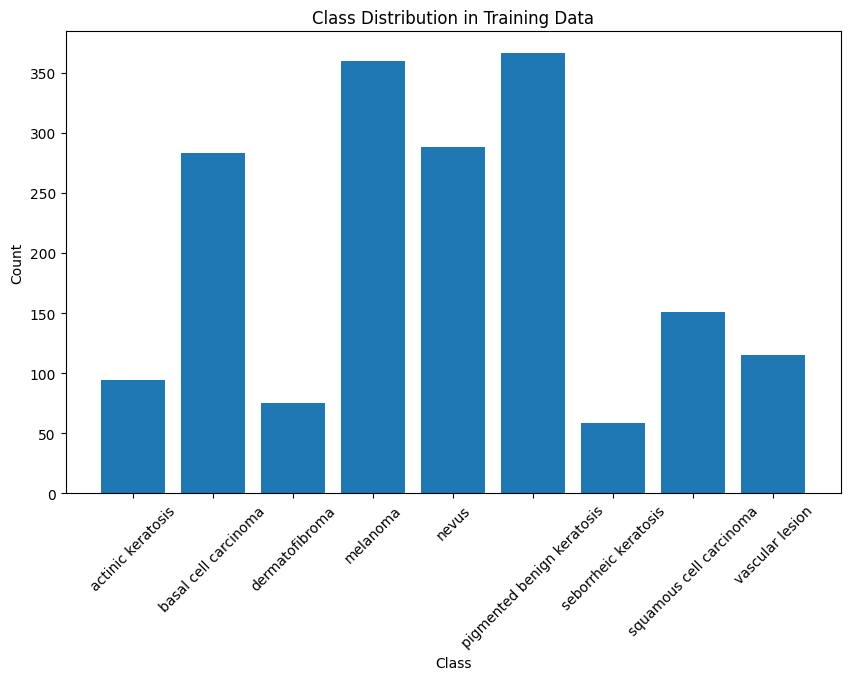

In [33]:

# Calculate class distribution from y_train (one-hot encoded labels)
class_distribution = np.sum(y_train, axis=0)
print(class_distribution)

# Get class names
class_names = sorted(os.listdir(train_folder))

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_distribution)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()


### Findings: Data imbalance is present